In [1]:
import os
import json

# Load credentials from JSON file
with open("config.json") as f:
    config_json = json.load(f)



In [2]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = config_json['SH_CLIENT_ID']
config.sh_client_secret = config_json['SH_CLIENT_SECRET']
config.save()

/Users/kamilkminkowski/studia/daes-project-2425-slodziaki-bystrzaki/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sentinelhub import (
    SentinelHubRequest, 
    DataCollection, 
    MimeType, 
    CRS, 
    BBox, 
    bbox_to_dimensions, 
    SHConfig
)

config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError("Missing SentinelHub credentials. Set CLIENT_ID and CLIENT_SECRET.")


lat, lon = 50.0647, 19.9450  # Kraków
lat, lon = 52.2298, 21.0118  # Warsaw
lat, lon = 48.8566, 2.3522  # Paris
lat, lon = 52.5200, 13.4050  # Berlin
# lat, lon = 51.5074, -0.1278  # London
# lat, lon = 40.7128, -74.0060  # New York
# lat, lon = 30.0444, 31.2357  # Cairo
# lat, lon = 55.7558, 37.6173  # Moscow

resolution = 30

bbox_size = 0.15
bbox = BBox([lon - 2 * bbox_size, lat - bbox_size, lon + 2 * bbox_size, lat + bbox_size], CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)


In [4]:
time_interval = ("2023-03-01", "2024-03-22")

evalscript = """
// SentinelHub Evalscript for cloud-free Sentinel-2 images
function setup() {
    return {
        input: ["B04", "B03", "B02", "SCL"],
        output: { bands: 3 }
    };
}

function evaluatePixel(sample) {
    // Mask clouds using SCL (Scene Classification Layer)
    if (sample.SCL == 3 || sample.SCL == 8 || sample.SCL == 9 || sample.SCL == 10) {
        return [0.05, 0.05, 0.05]; // Remove clouds, cloud shadows, and snow
    }
    return [sample.B04, sample.B03, sample.B02];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            mosaicking_order="leastCC"
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config
)

response = request.get_data()
image = np.array(response[0])

In [5]:
import numpy as np

def normalize_image(image, target_mean, target_std):
    """
    Normalize an image using percentile-based contrast stretching.
    
    Parameters:
        image (numpy.ndarray): Input image as a NumPy array.
        lower_percentile (int): Lower percentile for normalization (default=2).
        upper_percentile (int): Upper percentile for normalization (default=98).

    Returns:
        numpy.ndarray: Normalized image in the range 0-255.
    """
    
    image = image.astype(np.float32)
    mean = image.mean()
    std = image.std()
    
    image = (image - mean) / std
    image = target_std * image + target_mean
    image = np.clip(image, 0, 1)

    return image


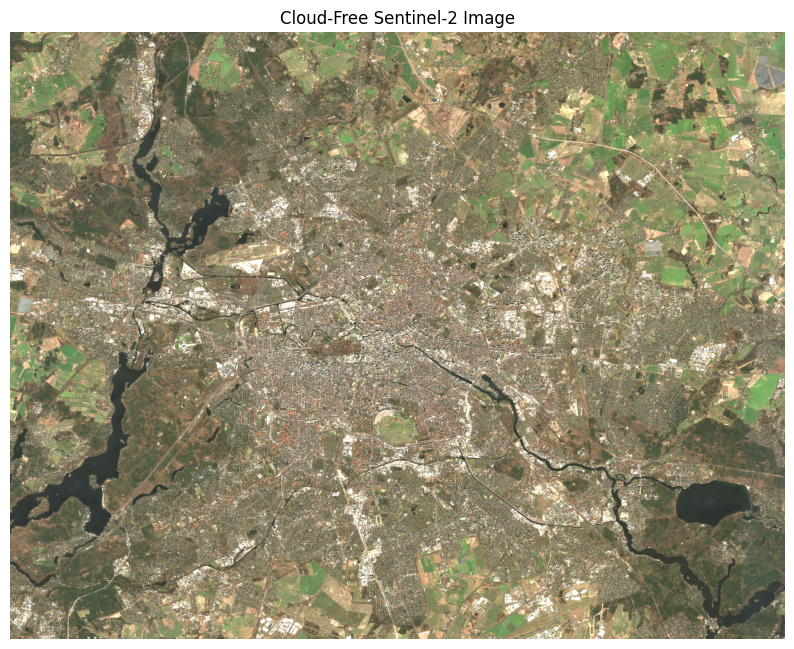

0.16722125 0.4933614


In [6]:
normalized_image = normalize_image(image, 0.5, 0.2)
plt.figure(figsize=(10, 10))
plt.imshow(normalized_image)
plt.axis("off")
plt.title("Cloud-Free Sentinel-2 Image")
plt.show()
print(normalized_image.std(), normalized_image.mean())

In [7]:
from PIL import Image

pil_image = Image.fromarray((normalized_image * 255).astype(np.uint8))

# Save the image as a PNG file
output_filename = "normalized_satellite_image.png"
pil_image.save(output_filename)